In [301]:
import numpy as np
import pandas as pd
import pandas.io.data as web
import matplotlib.pyplot as plt
import datetime

import mean_reversion as mr
import hedge_ratio as hr
import portfolio
import returns
import util

%matplotlib inline

In [429]:
#start_dt = datetime.datetime(2006, 4, 26)
#end_dt = datetime.datetime(2012, 4, 9)
start_dt = datetime.datetime(2015, 1, 1)
end_dt = datetime.datetime(2015, 12, 31)

In [430]:
# Interesting:
# USO, EWC, lookback=25, entryZScore=2, exitZScore=1, leverage=2
# DBC, DJP, lookback=20, entryZScore=1, exitZScore=0, 2012-12-11 -> 2015-12-31
# DBO, DJP, lookback=20, entryZScore=1, exitZScore=0, 2012-12-11 -> 2015-12-31
# DBO, EWA, lookback=15, entryZScore=1.0, exitZScore=0, 2012-12-11 -> 2015-12-31
# * DBO, DBC, lookback=15, entryZScore=1.4, exitZScore=0, 2012-12-11 -> 2015-12-31
# * GLD, DBC, lookback=10, entryZScore=1.0, exitZScore=0, 2012-12-11 -> 2015-12-31
# EWC, DJP, lookback=10, entryZScore=2.0, exitZScore=0.6, 2012-12-11 -> 2015-12-31


def fetch(ticker):
    global start_dt, end_dt
    return web.DataReader(ticker, 'yahoo', start_dt, end_dt)['Adj Close']

#SPY = fetch("SPY")
#DIA = fetch("DIA")
#QQQ = fetch("QQQ")
#IWM = fetch("IWM")
#GLD = fetch("GLD")
#USO = fetch("USO")
#DBO = fetch("DBO")
#EWA = fetch("EWA")
EWC = fetch("EWC")
#DBC = fetch("DBC")
DJP = fetch("DJP")
#UNG = fetch("UNG")


In [431]:
x = EWC
y = DJP

universe = pd.DataFrame({'x': x, 'y': y})

In [432]:
# Run a CADF and get better than 95%
mr.cadf(x, y, method="tls", regression="c")

(-3.2132393130343573,
 0.019231012499293321,
 1,
 238,
 {'1%': -3.458128284586202,
  '10%': -2.5732834559706235,
  '5%': -2.8737618352392862},
 70.438778917187335)

In [433]:
x.corr(y)

0.95081194005699521

Lookback: 5 -> CADF: mean 0.00, std 0.00
Lookback: 10 -> CADF: mean -2.63, std 1.09
Lookback: 20 -> CADF: mean -2.57, std 0.93
Lookback: 30 -> CADF: mean -2.44, std 0.86
Lookback: 50 -> CADF: mean -2.20, std 0.79


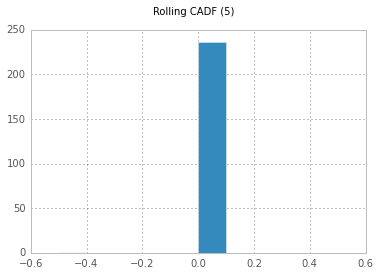

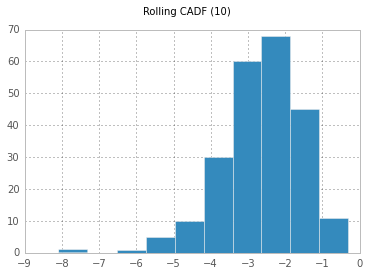

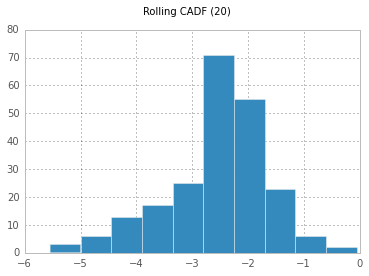

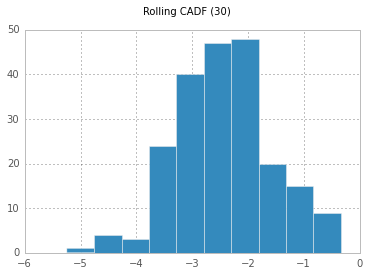

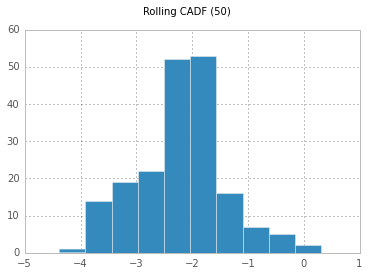

In [435]:
# There may be something to watching CADF over time instead
def cadf(win):
    return mr.cadf(
        win.x, 
        win.y, 
        method="tls", 
        regression="c")[0]

# Free param
for cadf_lookback in [5, 10, 20, 30, 50]:
    rolling_cadf = util.rolling_apply(
        universe, cadf_lookback, cadf)

    # We hope to see a mean down below -2 and -2.5, since this is where test
    # values start to get significant for the CADF test.
    plt.figure()
    plt.suptitle('Rolling CADF (%d)' % cadf_lookback)
    rolling_cadf.hist()
    print 'Lookback: %d -> CADF: mean %.2f, std %.2f' % (
        cadf_lookback, rolling_cadf.mean(), rolling_cadf.std())


array([ 10.32789314])

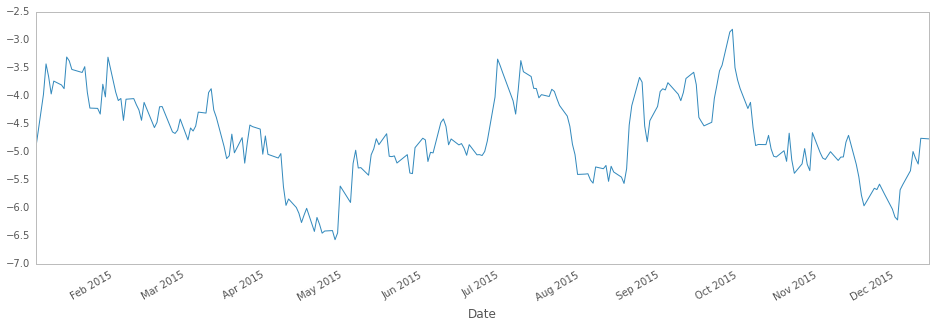

In [436]:
# Get static hedge ratio (warning, lookahead bias here)
static_hr = hr.hedge_ratio(x, y, method="tls")

# Construct base portfolio
port = y - static_hr * x
port.plot(figsize=(16,5))

mr.halflife(port)

In [437]:
# Reset these values for optimizing
lookback = 0
entryZScore = 1.0
exitZScore = 0.0

In [439]:
# Optimizing lookback...
# Plot some hedge lookback values against resulting sharpe ratio
import strategies
import optimize

strategy = lambda lookback: \
    strategies.rolling_hedge_mean_revert_strategy(x, y, lookback)
    
lookback_v_sharpe = optimize.vs_sharpe_table('lookback', [5, 10, 15, 20, 25, 30, 40, 50], strategy)
lookback_v_sharpe

,lookback,sharpe
0,5,2.748664
1,10,-1.075233
2,15,1.186128
3,20,0.000125
4,25,0.832801
5,30,1.429569
6,40,0.980133
7,50,0.180295


In [440]:
# lookback = 25
lookback = lookback_v_sharpe.sort('sharpe')['lookback'].iloc[-1]
lookback

5

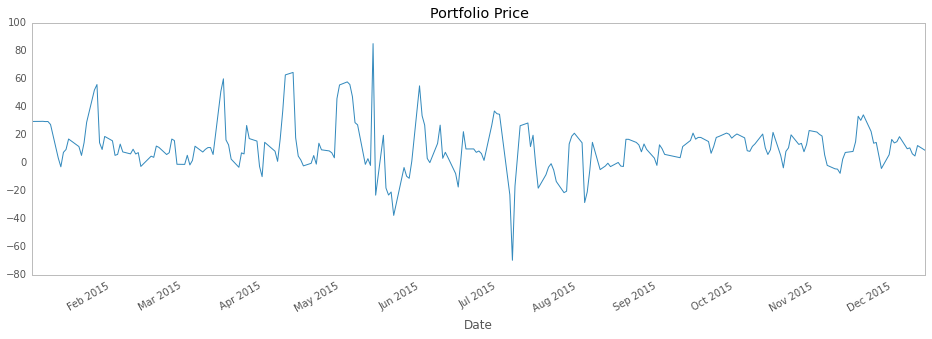

In [441]:
strategy = strategies.rolling_hedge_mean_revert_strategy
(prices, weights, units) = strategy(x, y, lookback)
port = portfolio.portfolio_price(prices, weights)
port.plot(figsize=(16,5), title='Portfolio Price')

In [442]:
# Ok, now let's look at the half-life of this portfolio, this needs to be low (under 30)
mr.halflife(port)

array([ 1.50061297])

In [443]:
# What does the adfuller look like for this rolling hedge portfolio?
# Does it show signs of mean reversion?
import statsmodels.tsa.stattools as sms
print 'CADF: %.2f' % sms.adfuller(port)[0]
print
print 'Hurst: %.2f' % mr.hurst_exponent(port.pct_change().fillna(0))[0]
print
print 'Vratio test'
print mr.vratiotest(port)


CADF: -8.20

Hurst: 0.62

Vratio test
            M1        M2
k=2   8.293464  4.805590
k=4   8.665084  5.567591
k=8   5.889885  4.241924
k=16  3.728150  2.892741
k=32  3.405894  2.768227


In [444]:
# Get returns for basic zScore continuous mean-reversion
zScore = util.rolling_z_score(port, lookback)
rets = portfolio.portfolio_returns(universe, weights, -zScore)
returns.annual_sharpe(rets[0])

2.7486640658551726

Bollinger Band Mean Reversion
        Total return: 0.246
        Sharpe ratio: 2.66
        APR: 0.264
        Drawdown: -0.03
        Max Time in Drawdown: 25
    
90 total trades
0.38 trades per day
2.67 days per trade
0.68% time in market
164 bars in market


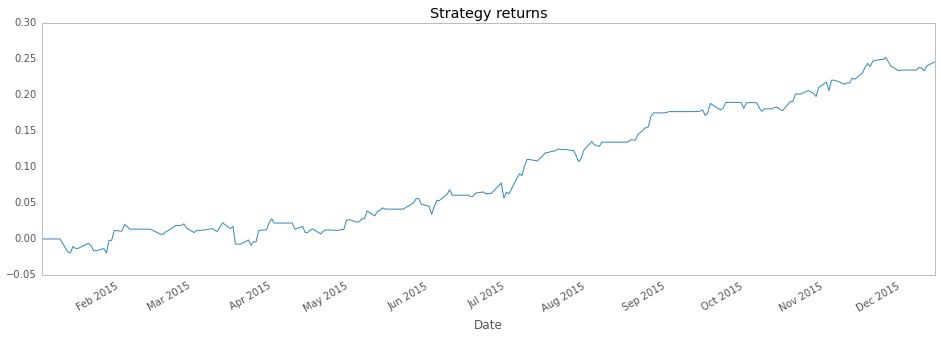

In [445]:
b_units = strategies.bollinger_band_units(zScore, entryZScore=entryZScore, exitZScore=exitZScore)

# Random experiment - static weights. Basically, force hedge weights to be static for the duration
# of any particular trade.
unit_changes = b_units != b_units.shift().fillna(0)
weights_v2 = weights.copy()
weights_v2[~unit_changes] = np.nan
weights_v2['x'][0] = 0
weights_v2['y'][0] = 0
weights_v2 = weights_v2.fillna(method='ffill')

#(b_rets, positions, pnl, grossMktVal) = portfolio.portfolio_returns(universe, weights_v2, b_units)
(b_rets, positions, pnl, grossMktVal) = portfolio.portfolio_returns(universe, weights, b_units)

b_rets = b_rets
print returns.report(b_rets, "Bollinger Band Mean Reversion")

# We want total trades to be high-ish (for statistic significance), but other
# than that, frequency might be a matter of preference? (Still figuring that out)
import strategies
reload(strategies)

print '%d total trades' % strategies.number_of_trades(b_units)
print '%.2f trades per day' % strategies.trades_per_period(b_units)
print '%.2f days per trade' % (1 / strategies.trades_per_period(b_units))
print '%.2f%% time in market' % strategies.time_in_market_percent(b_units)
print '%d bars in market' % len(b_units[b_units != 0])

returns.cumret(b_rets).plot(figsize=(16,5), title='Strategy returns')

In [403]:
# TODO: Figure out a way to measure "smoothness" of equity curve above, and trendiness as well

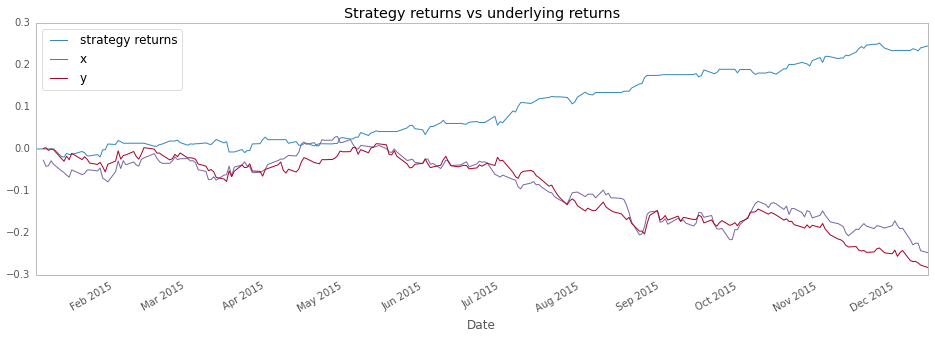

In [446]:
returns.cumret(pd.concat([
    pd.DataFrame({'strategy returns': b_rets}), 
    universe.pct_change()
], axis=1)).plot(figsize=(16,5), title='Strategy returns vs underlying returns')

In [447]:
# We want total trades to be high-ish (for statistic significance), but other
# than that, frequency might be a matter of preference? (Still figuring that out)
import strategies
reload(strategies)

print '%d total trades' % strategies.number_of_trades(b_units)
print '%.2f trades per day' % strategies.trades_per_period(b_units)
print '%.2f days per trade' % (1 / strategies.trades_per_period(b_units))
print '%.2f%% time in market' % strategies.time_in_market_percent(b_units)
print '%d bars in market' % len(b_units[b_units != 0])

90 total trades
0.38 trades per day
2.67 days per trade
0.68% time in market
164 bars in market


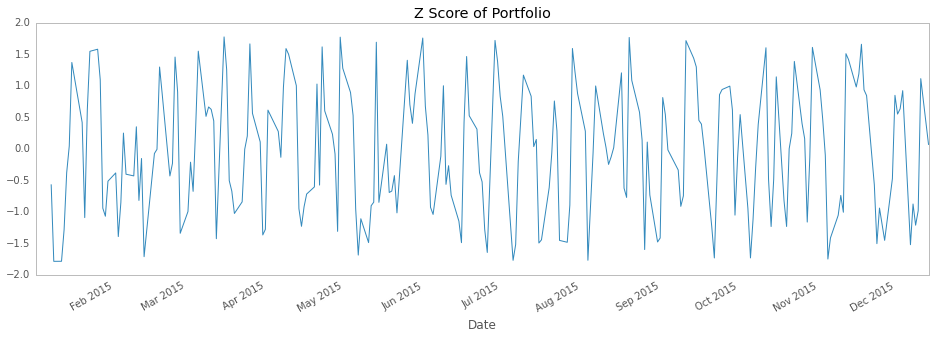

In [448]:
zScore.plot(figsize=(16,5), title="Z Score of Portfolio")

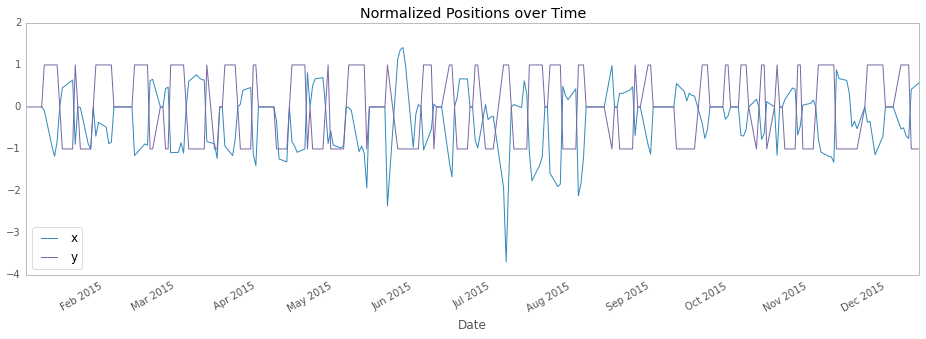

In [449]:
(weights * b_units).plot(figsize=(16,5), title='Normalized Positions over Time')